In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pylab as plt

from sigvisa import Sigvisa
from sigvisa.treegp.gp import GP, GPCov
%aimport sigvisa.models.spatial_regression.local_gp_ensemble 
%aimport sigvisa.learn.train_param_common

tpc = sigvisa.learn.train_param_common
lge = sigvisa.models.spatial_regression.local_gp_ensemble 



import sklearn.cluster

In [2]:
s = Sigvisa()
cursor = s.dbconn.cursor()
cursor.execute("select lon, lat, depth, mb from isc_origin where mb > 0")
V = np.array(cursor.fetchall())
cursor.close()
X = V[:, :3].copy()
y = V[:, 3].copy()

In [3]:


n = len(X)
target_size = 100

n_clusters = (n / target_size) * 2

depth_scale = 100.0
X_euclidean = X.copy()
X_euclidean[:, 2] /= depth_scale

km = sklearn.cluster.KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, 
                            max_iter=300, tol=0.0001, precompute_distances='auto', 
                            verbose=0, random_state=None, copy_x=True, n_jobs=1)
r = km.fit(X_euclidean)

assignments = r.predict(X_euclidean)
print "%d clusters of sizes %s" % (n_clusters, [np.sum(assignments==i) for i in range(n_clusters)])

46 clusters of sizes [39, 15, 26, 149, 118, 373, 9, 69, 72, 30, 33, 99, 33, 27, 240, 45, 25, 80, 47, 7, 27, 30, 14, 6, 25, 7, 22, 56, 10, 27, 57, 23, 16, 70, 28, 62, 33, 25, 13, 17, 4, 11, 62, 34, 81, 23]


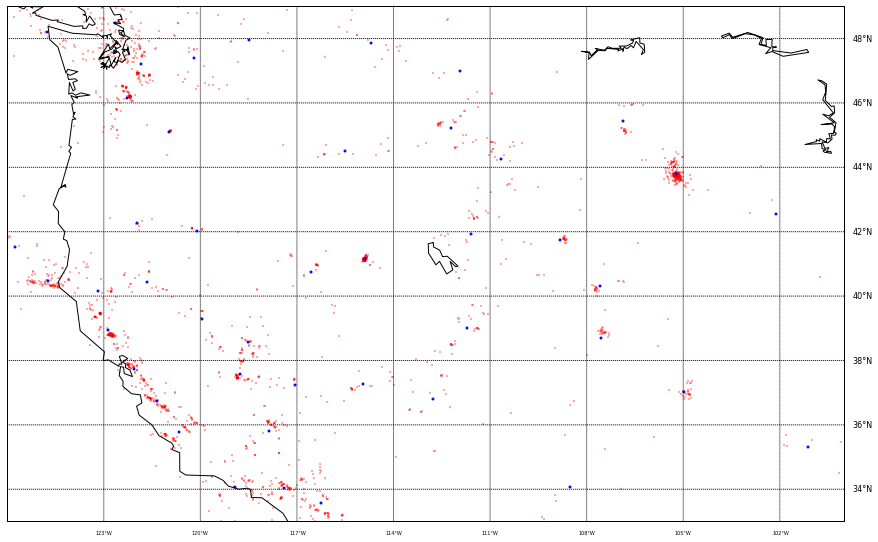

In [4]:
from sigvisa.plotting.event_heatmap import EventHeatmap

hm = EventHeatmap(f=None, left_lon=-126, right_lon=-100, top_lat=49, bottom_lat=33, calc=False)

f = plt.figure(figsize=(15, 15))
ax = plt.gca()
hm.init_bmap(axes=ax, nofillcontinents=True, projection="cyl")
hm.plot_earth()

normed_locations = np.array([hm.normalize_lonlat(*x[:2]) for x in X ])
scplot = hm.bmap.scatter(normed_locations[:, 0], normed_locations[:, 1], alpha=0.3, s=6, marker=".", color="red")

normed_centers= np.array([hm.normalize_lonlat(*x[:2]) for x in r.cluster_centers_ ])
scplot = hm.bmap.scatter(normed_centers[:, 0], normed_centers[:, 1], alpha=1.0, s=15, marker=".", color="blue")

In [6]:
cluster_centers = r.cluster_centers_.copy()
cluster_centers[:, 2] *= depth_scale

basic_cov = GPCov(wfn_str="matern32", wfn_params=(1.0,), dfn_str="lld", dfn_params=(30.0, 30.0))
cluster_covs = [basic_cov.copy() for i in range(n_clusters)]

cluster_noise_vars = [1.0 for i in range(n_clusters)]



In [6]:
from sigvisa.learn.train_param_common import pre_featurizer
basisfn_str="sin1"
basisfn_str, featurizer_recovery, extract_dim = pre_featurizer(basisfn_str)


In [13]:
from sigvisa.utils.geog import dist_km
sta_lon = -110
sta_lat = 45

XX = np.array([(lon, lat, depth, dist_km((lon, lat), (sta_lon, sta_lat)), 0.0) for (lon, lat, depth) in X])

# Test: zero-param limit

We want to show that adding a parametric component with all parameters forced to zero by the prior is equivalent to the original, plain, model.

In [14]:
lgp = lge.LocalGPEnsemble(XX, y, 
                          cluster_centers=cluster_centers, 
                          cluster_covs = cluster_covs,
                          cluster_noise_vars = cluster_noise_vars)

param_mean = np.zeros((4,))
param_cov = np.eye(4)*0.00000001
lgp_param_zerolimit = lge.LocalGPEnsemble(XX, y, 
                          cluster_centers=cluster_centers, 
                          cluster_covs = cluster_covs,
                          cluster_noise_vars = cluster_noise_vars,
                          basis=basisfn_str,
                          extract_dim=extract_dim,
                          featurizer_recover=featurizer_recovery,
                          param_mean=param_mean,
                          param_cov=param_cov)
print lgp_param_zerolimit.beta_bar

[  5.43054129e-06  -1.66698618e-05   2.03878768e-06   4.95869144e-06]


In [34]:
X1 = XX[0:1, :]
print X1
print y[0]
print lgp.predict(X1), lgp_param_zerolimit.predict(X1)
print lgp.variance(X1, include_obs=False), lgp_param_zerolimit.variance(X1, include_obs=False)


[[-105.2442       43.5355        0.          412.12575821    0.        ]]
2.5
3.22785267023 [[ 3.22785407]]
0.0823459283678 0.082345928426


In [35]:
print lgp._compute_marginal_likelihood()
print lgp_param_zerolimit._compute_marginal_likelihood()

-3472.08660446
-3472.06977882


In [36]:
print lgp._log_likelihood_gradient()[:10]
print lgp_param_zerolimit._log_likelihood_gradient()[:10]

[ -4.05847166e+01   8.32730332e+00   5.77440618e-01   5.40639903e-02
  -1.27873733e+02   1.09566122e+01   1.04201072e+00   6.64621220e-04
  -7.78633650e+01   6.28044710e+00]
[ -4.05848067e+01   8.32685143e+00   5.77424684e-01   5.40629579e-02
  -1.27873879e+02   1.09558062e+01   1.04197791e+00   6.64596046e-04
  -7.78635215e+01   6.27980360e+00]


# Test: zero-GP limit

Using a param GP with the GP signal variance set to near-zero should be equivalent to just using a param model.

In [57]:

basic_cov = GPCov(wfn_str="matern32", wfn_params=(0.1,), dfn_str="lld", dfn_params=(30.0, 30.0))
cluster_covs = [basic_cov.copy() for i in range(n_clusters)]

param_mean = np.zeros((4,))
param_cov = np.eye(4)*10.0
lgp_gp_zerolimit = lge.LocalGPEnsemble(XX, y, 
                          cluster_centers=cluster_centers, 
                          cluster_covs = cluster_covs,
                          cluster_noise_vars = cluster_noise_vars,
                          basis=basisfn_str,
                          extract_dim=extract_dim,
                          featurizer_recover=featurizer_recovery,
                          param_mean=param_mean,
                          param_cov=param_cov)


In [58]:
from sigvisa.models.spatial_regression.linear_basis import LinearBasisModel
lbm = LinearBasisModel(X=XX, y=y, yvars=None, 
                       basis=basisfn_str, 
                       param_mean=param_mean, 
                       param_cov=param_cov, 
                       noise_std=1, 
                       featurizer_recovery=featurizer_recovery, 
                       compute_ll=True, 
                       extract_dim=extract_dim)

In [59]:
print lbm.mean
print lgp_gp_zerolimit.beta_bar

[  6.52472337  -2.87790456   1.2720093  -14.06055072]
[ 3.60460649 -1.63730525  1.70685674 -6.99340797]


In [60]:
print lgp_gp_zerolimit._compute_marginal_likelihood()
print lbm.ll



-2500.50056049
-2570.81407407


In [46]:
X1 = XX[0:1, :]
print lbm.predict(X1), lgp_gp_zerolimit.predict(X1)
print lbm.variance(X1, include_obs=False), lgp_gp_zerolimit.variance(X1, include_obs=False)


[ 3.21722357] [[ 3.21722801]]
[ 0.00122613] 0.00122619881234


# Basic Optimization

In [90]:
from sigvisa.models.distributions import InvGamma, LogNormal
from sigvisa.models.spatial_regression.local_gp_ensemble import optimize_localgp_hyperparams

noise_prior = InvGamma(1.0,1.0)
cov_main =  GPCov([3.4,], [ 100.0, 40.0], dfn_str="lld",
              wfn_priors=[InvGamma(beta=5.0, alpha=.5),],
              dfn_priors =[LogNormal(mu=5, sigma=1.0), LogNormal(mu=3, sigma=1.0)])

nllgrad, x0, build_gp, covs_from_vector = optimize_localgp_hyperparams(cluster_centers=cluster_centers, 
                                                                  noise_prior=noise_prior,
                                                                  cov_main=cov_main, X=XX, y=y)

       

In [92]:
import scipy.optimize

def smallnll(x8):
    x0[:8] = x8
    ll, grad = nllgrad(x0)
    return ll
x8 = x0[:8].copy()

ll, g1 = nllgrad(x0)
gg = scipy.optimize.approx_fprime(x8, smallnll, 1e-4)
print g1[:8]
print gg

[  2.45261181   1.08487729  -5.35450566   0.19415162  16.23985797
   0.99744778  -9.17064534  -2.27296641]
[  2.45300299   1.08509118  -5.35429474   0.19427528  16.2407014
   0.99773407  -9.1701224   -2.27280402]


In [82]:
r = scipy.optimize.minimize(nllgrad, x0, jac=True)

In [ ]:
cluster_covs, cluster_noise_vars = covs_from_vector(np.exp(r.x))
print cluster_covs

# Training pipeline

In [ ]:
from sigvisa.infer.optimize.optim_utils import construct_optim_params
from sigvisa.utils.geog import dist_km

optim_params = construct_optim_params("'disp': True")
print optim_params

s = Sigvisa()
sta_lon, sta_lat = s.earthmodel.site_info('PD31', 0)[:2]

XX = np.array([(lon, lat, depth, dist_km((lon, lat), (sta_lon, sta_lat)), 0.0) for (lon, lat, depth) in X])

XX = XX[:400].copy()
yy = y[:400].copy()

gp = tpc.learn_localgp(sta="PD31", X=XX, y=yy, y_obs_variances=None, kernel_str="lld", 
                       basisfn_str="sin1", target="amp_transfer", 
                       optim_params=optim_params,
                       cluster_centers_fname="/home/dmoore/python/sigvisa/isc_clusters")